### Satvik Varshney ; Waterloo ID: 20764052
#### Phys 449 , Main Assignment
#### Submission date : 06 Dec 2022

In [1]:
#Importing Necessary Libraries

# Data read/write libraries
import pandas as pd
import json
import sys

# Data calculation and manipulation libraries
import numpy as np
import random
from sklearn import preprocessing

#PyTorch Specific libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

from torch import nn, optim
from tqdm import tqdm

#plaotting the chart
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sn


In [2]:
# Build the petrov type determination Model 
class model_petrovtype_classification(nn.Module):
    def __init__(self):   
        super().__init__()
        
        self.hidden_layer_1 = nn.Linear(num_input, num_hidden)  # 5,500
        self.hidden_layer_2 = nn.Linear(num_hidden, num_hidden)   # 500,500
        self.hidden_layer_3 = nn.Linear(num_hidden, num_hidden)   # 500,500
        self.hidden_layer_4 = nn.Linear(num_hidden, num_hidden)   # 500,500
        self.output_layer = nn.Linear(num_hidden, num_classes)   # 500, 6

        # Reset the layers
        self.hidden_layer_1.reset_parameters()
        self.hidden_layer_2.reset_parameters()
        self.hidden_layer_3.reset_parameters()
        self.hidden_layer_4.reset_parameters()
        self.output_layer.reset_parameters()
        
        self.activation_layer1 = nn.Tanh()
        self.dropout_layer1 = nn.Dropout(p=0.2)
        self.activation_layer2 = nn.Sigmoid()
        self.dropout_layer2 = nn.Dropout(p=0.2)
        self.activation_layer3 = nn.Tanh()
        self.dropout_layer3 = nn.Dropout(p=0.2)
        self.activation_layer4 = nn.Sigmoid()
        self.dropout_layer4 = nn.Dropout(p=0.2)
        self.activation_outputlayer = nn.Softmax(dim=1)

        self.loss = nn.CrossEntropyLoss() # Loss used for multi variate analysis
        self.optimizer = optim.Adam(self.parameters(), lr)

    def forward(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.activation_layer1(x)
        x = self.dropout_layer1(x)
        x = self.hidden_layer_2(x)
        x = self.activation_layer2(x)
        x = self.dropout_layer2(x)
        x = self.hidden_layer_3(x)
        x = self.activation_layer3(x)
        x = self.dropout_layer3(x)
        x = self.hidden_layer_4(x)
        x = self.activation_layer4(x)
        x = self.dropout_layer4(x)
        x = self.output_layer(x)
        x = self.activation_outputlayer(x)
        return x

    def fit(self, X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred, Y)
        y_pred_max = torch.argmax(y_pred, axis=1)
        train_accuracy = (Y == y_pred_max).sum()
        loss.backward()   #backpropagation
        self.optimizer.step()   # updating the weights
        return loss.item(), train_accuracy

    def evaluate(self,test_dataloader):
        acc_test = 0
        loss_test= 0
        for X,Y in test_dataloader:
            with torch.no_grad():
                loss_temp = self.loss(self.forward(X.float()), Y.long())
                # just to manage the error relted to numpy and tensor
                loss_temp = loss_temp.detach().numpy()
                loss_test += loss_temp
                # to calculate the test accuracy
                y_pred_test = torch.argmax(self.forward(X.float()), axis=1)
                acc_test += (Y == y_pred_test).sum()   # batch

        avg_acc_test = acc_test / (len(test_dataloader)* batch)
        avg_loss_test = loss_test/len(test_dataloader)

        return avg_acc_test ,avg_loss_test
    
    def determine_petrov(self,X):
        with torch.no_grad():
            y_pred_test= self.forward(X)
            return torch.argmax(y_pred_test, axis=1)


In [3]:
class class_data_tranformation:
    # convert pertov types to intergers
    def fn_convert_petrov_classification_data(self, y):
        y_converted = []
        for idx, y_val in enumerate(y):
            if y_val == "O": y_converted.append(0)
            elif y_val == "I": y_converted.append(1)
            elif y_val == "II": y_converted.append(2)
            elif y_val == "III": y_converted.append(3)
            elif y_val == "D": y_converted.append(4)
            elif y_val == "N": y_converted.append(5)
        return y_converted
    # splite data into 30% train, 15% valdation and 15% test datasets
    def fn_split_train_val_test(self, data):
        # separate the last colums as y-data
        Y = data[:,5] 
        X = np.delete(data, 5,1)  # Input data
        y = np.array(self.fn_convert_petrov_classification_data(Y))
        total_rows, total_cols = data.shape
        testdata_rows = int(total_rows*30/100) # 30% test data
        # separate the test data Last 30% records
        x_test_temp = X[-testdata_rows:, :]
        y_test_temp = y[-testdata_rows:]

        # build the training data 70%
        x_train  = X[:-len(x_test_temp), :] 
        y_train = y[:-len(y_test_temp)] 

        # separate 15% as validation data from Test data 15%
        x_test = x_test_temp[-int(testdata_rows/2):, :]
        y_test = y_test_temp[-int(testdata_rows/2):]

        # build the validartion data 15%
        x_val  = x_test_temp[:-len(x_test), :] 
        y_val = y_test_temp[:-len(y_test)] 

        # change the dtype to 'float64'
        x_train = x_train.astype('float64')
        x_test = x_test.astype('float64')  
        x_val = x_val.astype('float64')   

        return x_train, y_train, x_val, y_val, x_test, y_test

Fitting epoch 1:   0%|▎                                                               | 9/2133 [00:00<00:26, 80.46it/s]

Epoch 1 Training Loss = : 1.4831 and Accuracy = : 0.5514
Epoch 1 Validation Loss = : 1.1802 and Accuracy = : 0.8646


Fitting epoch 2:   0%|▎                                                               | 9/2133 [00:00<00:25, 81.97it/s]

Epoch 2 Training Loss = : 1.1572 and Accuracy = : 0.8867
Epoch 2 Validation Loss = : 1.1532 and Accuracy = : 0.8893


Fitting epoch 3:   0%|▏                                                               | 8/2133 [00:00<00:27, 76.32it/s]

Epoch 3 Training Loss = : 1.1097 and Accuracy = : 0.9338
Epoch 3 Validation Loss = : 1.1006 and Accuracy = : 0.9415


Fitting epoch 4:   0%|▏                                                               | 8/2133 [00:00<00:28, 74.24it/s]

Epoch 4 Training Loss = : 1.0964 and Accuracy = : 0.9469
Epoch 4 Validation Loss = : 1.0922 and Accuracy = : 0.9491


Fitting epoch 5:   0%|▏                                                               | 7/2133 [00:00<00:32, 64.46it/s]

Epoch 5 Training Loss = : 1.0918 and Accuracy = : 0.9515
Epoch 5 Validation Loss = : 1.0880 and Accuracy = : 0.9533


Fitting epoch 6:   0%|▏                                                               | 8/2133 [00:00<00:29, 72.08it/s]

Epoch 6 Training Loss = : 1.0772 and Accuracy = : 0.9662
Epoch 6 Validation Loss = : 1.0834 and Accuracy = : 0.9576


Fitting epoch 7:   0%|▏                                                               | 8/2133 [00:00<00:28, 74.82it/s]

Epoch 7 Training Loss = : 1.0731 and Accuracy = : 0.9704
Epoch 7 Validation Loss = : 1.0723 and Accuracy = : 0.9697


Fitting epoch 8:   0%|▎                                                               | 9/2133 [00:00<00:27, 77.85it/s]

Epoch 8 Training Loss = : 1.0720 and Accuracy = : 0.9714
Epoch 8 Validation Loss = : 1.0759 and Accuracy = : 0.9666


Fitting epoch 9:   0%|▏                                                               | 8/2133 [00:00<00:28, 73.82it/s]

Epoch 9 Training Loss = : 1.0697 and Accuracy = : 0.9738
Epoch 9 Validation Loss = : 1.0689 and Accuracy = : 0.9726


Fitting epoch 10:   0%|▏                                                              | 8/2133 [00:00<00:28, 74.02it/s]

Epoch 10 Training Loss = : 1.0692 and Accuracy = : 0.9743
Epoch 10 Validation Loss = : 1.0646 and Accuracy = : 0.9771


Fitting epoch 11:   0%|▏                                                              | 8/2133 [00:00<00:28, 75.40it/s]

Epoch 11 Training Loss = : 1.0681 and Accuracy = : 0.9754
Epoch 11 Validation Loss = : 1.0669 and Accuracy = : 0.9732


Fitting epoch 12:   0%|▏                                                              | 8/2133 [00:00<00:28, 73.66it/s]

Epoch 12 Training Loss = : 1.0666 and Accuracy = : 0.9768
Epoch 12 Validation Loss = : 1.0662 and Accuracy = : 0.9755


Fitting epoch 13:   0%|▏                                                              | 8/2133 [00:00<00:28, 75.12it/s]

Epoch 13 Training Loss = : 1.0670 and Accuracy = : 0.9764
Epoch 13 Validation Loss = : 1.0635 and Accuracy = : 0.9783


Fitting epoch 14:   0%|▏                                                              | 8/2133 [00:00<00:28, 74.48it/s]

Epoch 14 Training Loss = : 1.0664 and Accuracy = : 0.9771
Epoch 14 Validation Loss = : 1.0603 and Accuracy = : 0.9810


Fitting epoch 15:   0%|▏                                                              | 7/2133 [00:00<00:31, 67.12it/s]

Epoch 15 Training Loss = : 1.0664 and Accuracy = : 0.9771
Epoch 15 Validation Loss = : 1.0609 and Accuracy = : 0.9803


Fitting epoch 16:   0%|▏                                                              | 7/2133 [00:00<00:32, 65.76it/s]

Epoch 16 Training Loss = : 1.0650 and Accuracy = : 0.9784
Epoch 16 Validation Loss = : 1.0638 and Accuracy = : 0.9775


Fitting epoch 17:   0%|▏                                                              | 8/2133 [00:00<00:29, 72.35it/s]

Epoch 17 Training Loss = : 1.0655 and Accuracy = : 0.9780
Epoch 17 Validation Loss = : 1.0628 and Accuracy = : 0.9794


Fitting epoch 18:   0%|▏                                                              | 7/2133 [00:00<00:32, 65.11it/s]

Epoch 18 Training Loss = : 1.0646 and Accuracy = : 0.9789
Epoch 18 Validation Loss = : 1.0668 and Accuracy = : 0.9749


Fitting epoch 19:   0%|▏                                                              | 7/2133 [00:00<00:31, 67.95it/s]

Epoch 19 Training Loss = : 1.0638 and Accuracy = : 0.9797
Epoch 19 Validation Loss = : 1.0631 and Accuracy = : 0.9780


Fitting epoch 20:   0%|▏                                                              | 7/2133 [00:00<00:31, 67.38it/s]

Epoch 20 Training Loss = : 1.0621 and Accuracy = : 0.9814
Epoch 20 Validation Loss = : 1.0779 and Accuracy = : 0.9626


Fitting epoch 21:   1%|▍                                                             | 14/2133 [00:00<00:34, 62.12it/s]

Epoch 21 Training Loss = : 1.0627 and Accuracy = : 0.9808
Epoch 21 Validation Loss = : 1.0617 and Accuracy = : 0.9798


Fitting epoch 22:   0%|▏                                                              | 7/2133 [00:00<00:32, 64.85it/s]

Epoch 22 Training Loss = : 1.0640 and Accuracy = : 0.9795
Epoch 22 Validation Loss = : 1.0737 and Accuracy = : 0.9676


Fitting epoch 23:   0%|▏                                                              | 6/2133 [00:00<00:36, 58.71it/s]

Epoch 23 Training Loss = : 1.0639 and Accuracy = : 0.9795
Epoch 23 Validation Loss = : 1.0667 and Accuracy = : 0.9749


Fitting epoch 24:   0%|▏                                                              | 6/2133 [00:00<00:37, 56.90it/s]

Epoch 24 Training Loss = : 1.0617 and Accuracy = : 0.9818
Epoch 24 Validation Loss = : 1.0605 and Accuracy = : 0.9819


Fitting epoch 25:   0%|▏                                                              | 6/2133 [00:00<00:38, 55.24it/s]

Epoch 25 Training Loss = : 1.0615 and Accuracy = : 0.9820
Epoch 25 Validation Loss = : 1.0577 and Accuracy = : 0.9837


Fitting epoch 26:   0%|▏                                                              | 6/2133 [00:00<00:39, 53.85it/s]

Epoch 26 Training Loss = : 1.0612 and Accuracy = : 0.9822
Epoch 26 Validation Loss = : 1.0642 and Accuracy = : 0.9769


Fitting epoch 27:   0%|▏                                                              | 6/2133 [00:00<00:37, 56.10it/s]

Epoch 27 Training Loss = : 1.0614 and Accuracy = : 0.9821
Epoch 27 Validation Loss = : 1.0648 and Accuracy = : 0.9763


Fitting epoch 28:   0%|▏                                                              | 5/2133 [00:00<00:45, 47.08it/s]

Epoch 28 Training Loss = : 1.0625 and Accuracy = : 0.9810
Epoch 28 Validation Loss = : 1.0573 and Accuracy = : 0.9853


Fitting epoch 29:   0%|▏                                                              | 5/2133 [00:00<00:45, 46.83it/s]

Epoch 29 Training Loss = : 1.0608 and Accuracy = : 0.9826
Epoch 29 Validation Loss = : 1.0549 and Accuracy = : 0.9865


Fitting epoch 29: 100%|████████████████████████████████████████████████████████████| 2133/2133 [00:37<00:00, 57.21it/s]


Epoch 30 Training Loss = : 1.0634 and Accuracy = : 0.9800
Epoch 30 Validation Loss = : 1.0573 and Accuracy = : 0.9843
Pridicting the inout digit and checking the accuracy of prediction
Input digit: 
tensor([4, 2, 1, 0, 2, 3, 0, 1, 3, 2, 2, 5, 2, 0, 0, 2, 1, 4, 5, 1, 1, 1, 1, 1,
        3, 2, 2, 0, 4, 1, 1, 1, 1, 4, 1, 2, 5, 3, 4, 1, 1, 3, 2, 2, 1, 2, 1, 2,
        2, 4, 1, 3, 1, 1, 1, 5, 1, 0, 0, 2, 1, 0, 0, 3, 4, 3, 4, 1, 5, 1, 1, 1,
        0, 1, 4, 1, 1, 3, 1, 1, 1, 5, 2, 2, 2, 1, 1, 0, 0, 2, 2, 3, 4, 2, 0, 1,
        0, 4, 0, 2, 0, 3, 2, 3, 2, 4, 1, 0, 4, 1, 1, 1, 1, 4, 2, 0, 1, 4, 3, 2,
        4, 1, 2, 0, 1, 2, 2, 1])
Predicted digit: 
tensor([4, 2, 1, 0, 2, 3, 0, 1, 3, 2, 2, 5, 2, 0, 0, 2, 1, 4, 5, 1, 1, 1, 1, 1,
        3, 2, 2, 0, 4, 1, 1, 1, 1, 4, 1, 2, 5, 3, 1, 1, 1, 3, 2, 2, 1, 2, 1, 2,
        2, 4, 1, 3, 1, 1, 1, 5, 1, 0, 0, 2, 1, 0, 0, 3, 4, 3, 1, 1, 5, 1, 1, 1,
        0, 1, 4, 1, 1, 3, 3, 1, 1, 5, 2, 2, 2, 1, 1, 0, 0, 2, 2, 3, 4, 2, 0, 1,
        0, 4, 0, 1, 0, 3, 2, 3

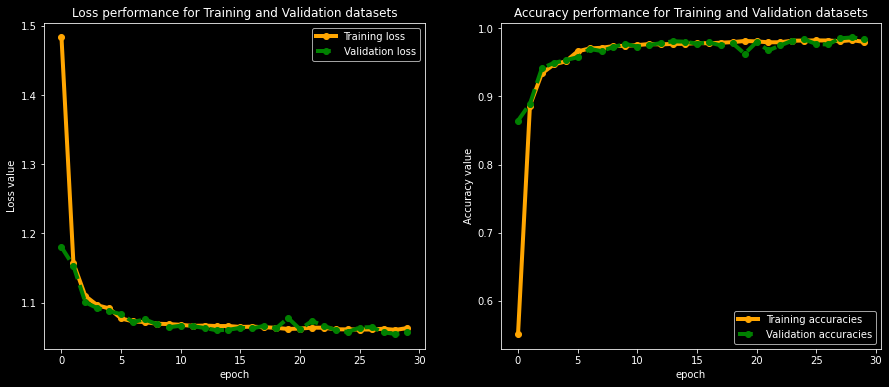

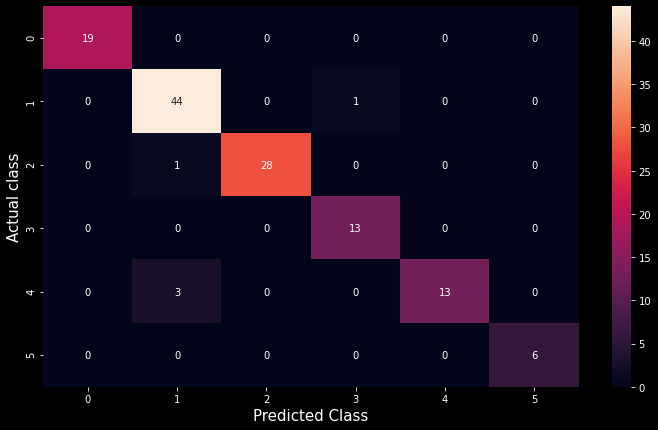

In [4]:
if __name__ == "__main__":
    
    if sys.argv[1] == "--help":
        print ("Syntax = python main.py param/param_file_name.json petrov_data.csv performance.html")
        print ("Parameter 1 = param/param_file_name.json ")
        print ("  Parameter 1 description = JSON file to keep the hyper parameters (e.g. learning rate, batch size, etc.)")
        print ("  Parameter 1 default value = param/param_file_name.json")
        print ("  Parameter 1 file type = JSON")
        print ("Parameter 2 = even_mnist.csv ")
        print ("  Parameter 2 description = Petrov Input dataset file name with path")
        print ("  Parameter 2 default value = even_mnist.csv")
        print ("  Parameter 2 file type = csv")
        print ("Parameter 3 = performance.html ")
        print ("  Parameter 3 description = html file name with path to record the output.This report summarizes the final results and performance.")
        print ("  Parameter 3 default value = result/Performance.html")
        print ("  Parameter 3 file type = html")
    else:
        if len(sys.argv) == 4: 
            json_file = sys.argv[1] #param/param_file_name.json
            dataset_url = sys.argv[2] #'even_mnist.csv'
            outputfilename = sys.argv[3] # performance.html
        else:
            json_file = "param/param_file_name.json" 
            dataset_url = "petrov_data.csv"
            outputfilename = "result/Performance.html"
            
        obj_dt = class_data_tranformation()
        # reading csv file
        df = pd.read_csv(dataset_url, sep=',', header=None)
        data = df.to_numpy() # convert dataframe to array
        x_train, y_train, x_val, y_val, x_test, y_test  = obj_dt.fn_split_train_val_test(data)

        # Importing json file to read the parametes
        f = open(json_file)
        dt_json = json.load(f)
        lr = dt_json['learning rate']
        # specify input dimensions of each image
        num_input = dt_json['num_input'] #5
        # batch size, number of classes, epochs
        batch = dt_json['batch_size']#128
        num_classes = dt_json['num_classes']#6
        epochs = dt_json['num iter']
        num_hidden = dt_json['num_hidden']

        # normalise datasets
        x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
        x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())
        x_val = (x_val - x_val.min()) / (x_val.max() - x_val.min())
        
        #Converting to Tensors
        X_train = torch.from_numpy(x_train)
        X_test = torch.from_numpy(x_test)
        X_val = torch.from_numpy(x_val)

        y_train = torch.from_numpy(y_train).type(torch.LongTensor)
        y_test = torch.from_numpy(y_test).type(torch.LongTensor)
        y_val = torch.from_numpy(y_val).type(torch.LongTensor)

        train = torch.utils.data.TensorDataset(X_train, y_train)
        test = torch.utils.data.TensorDataset(X_test, y_test)
        val = torch.utils.data.TensorDataset(X_test, y_test)

        # Set our data loaders into batches
        train_loader = torch.utils.data.DataLoader(train, batch_size = batch, shuffle = True)
        test_loader = torch.utils.data.DataLoader(test, batch_size = batch, shuffle = True)
        val_loader = torch.utils.data.DataLoader(val, batch_size = batch, shuffle = True)

        # Open output html file 
        outputfilename_sub = outputfilename[:len(outputfilename)-5]
        objOutputFile = open(outputfilename,"w")
        # Adding header data to the HTML file
        objOutputFile.write("<html>\n<head><title bgcolor='#2980B9'> \nPerformance Report \</title></head> <body><h1>Physics 449 Main Assignment</h1></body></html>")
        objOutputFile.write("<table>")
        
        #Building the Model
        obj_model_petrov = model_petrovtype_classification().to(torch.device("cpu"))

        # Initialize the vectors for performance tracking and display for train and test dataset
        train_val_loss = []
        train_val_acc = []
        validation_val_loss = []
        validation_val_acc=[]

        for i in range(epochs):
            # Train the system
            total_loss = 0
            total_acc = 0
            for X,Y in tqdm(train_loader, desc = f"Fitting epoch {i}"):
                loss, acc = obj_model_petrov.fit(X.float(),Y.long())
                total_loss += loss
                total_acc +=acc
            avg_loss = total_loss/len(train_loader)
            avg_acc = total_acc / (len(train_loader)* batch)
            train_val_loss.append(avg_loss)
            train_val_acc.append(avg_acc)
            # Evaluate the model
            acc_test,loss_test = obj_model_petrov.evaluate(val_loader)
            validation_val_loss.append(loss_test)
            validation_val_acc.append(acc_test)
            # Training, test data loss and accuray recording
            training_performance_str = f"Epoch {i+1} Training Loss = : {avg_loss:.4f} and Accuracy = : {avg_acc:.4f}"
            validation_performance_str = f"Epoch {i+1} Validation Loss = : {loss_test:.4f} and Accuracy = : {acc_test:.4f}"
            # Pring Training and test data loss, accuray information to screen
            print(training_performance_str)
            print(validation_performance_str)
            # Write Training and test data loss, accuray information to output html file
            objOutputFile.write("<tr><td>"+training_performance_str+"</td></tr>")
            objOutputFile.write("<tr><td>"+validation_performance_str+"<//td><tr>")
            objOutputFile.write("<tr><td></td></tr>")
            objOutputFile.write("<tr><td></td></tr>")
            
        #plot training loss and accurasies
        plt.style.use('dark_background')
        plt.figure(figsize=(15,6))
        plt.subplot(121)
        plt.plot(range(epochs), train_val_loss, label= "Training loss", color="orange", linewidth=4,marker='o')
        plt.plot(range(epochs), validation_val_loss, label= "Validation loss", color="green", linewidth=4 ,linestyle='--', marker='o')
        plt.legend()
        plt.title ("Loss performance for Training and Validation datasets") 
        plt.xlabel("epoch")
        plt.ylabel("Loss value")
        plt.subplot(122)
        plt.plot(range(epochs), train_val_acc, label= "Training accuracies", color= "orange", linewidth=4,marker='o')
        plt.plot(range(epochs), validation_val_acc, label= "Validation accuracies", color= "green", linewidth=4,linestyle='--', marker='o')
        plt.legend()
        plt.title ("Accuracy performance for Training and Validation datasets") 
        plt.xlabel("epoch")
        plt.ylabel("Accuracy value")
        # Saving the chart to png file
        pngfilename = outputfilename_sub+"_graphs.png"
        plt.savefig(pngfilename)
        #time.sleep(2)
        # chart display
        #plt.show (block=True)
        plt.show

        # embedding the chart png into the HTML file
        pngfilename_1 = pngfilename.split("/")[1]#"Performance_graphs.png"
        performance_str = f"------------- Accuracy and Loss Performance ------------- "
        objOutputFile.write("<tr><td>"+performance_str+"</td></tr>")
        objOutputFile.write("<tr><td></td></tr>")
        objOutputFile.write("<tr><td></td></tr>")
        objOutputFile.write("<tr><td><img src="+pngfilename_1+"></img></td></tr>")
        objOutputFile.write("</table></body></html>")              
        objOutputFile.write("<tr><td></td></tr>")
        
        # Predict the petrov type
        CM_pngfilename = outputfilename_sub+"_CM.png"
        # constant for classes
        petrov_classes = ('O', 'I', 'II', 'III', 'D','N')
        for X,Y in test_loader:
            y_predicted = obj_model_petrov.determine_petrov(X.float())
            
            print ("Pridicting the inout digit and checking the accuracy of prediction")
            print ("Input digit: ")
            print (Y)
            print("Predicted digit: ")
            print (y_predicted)
            print("Accuracy of prediction: ")
            print (Y==y_predicted)


            # Build confusion matrix
            cf_matrix = confusion_matrix(Y, y_predicted)
            plt.figure(figsize = (12,7))
            sn.heatmap(cf_matrix, annot=True)
            plt.xlabel('Predicted Class', fontsize = 15) 
            plt.ylabel('Actual class', fontsize = 15) 
            plt.savefig(CM_pngfilename)
            plt.show

            # embedding the heatmap chart png into the HTML file
            CM_pngfilename_1 = CM_pngfilename.split("/")[1]#"Performance_CM.png"
            objOutputFile.write("<table>")
            CM_str = f"------------- Confusion Matrix ------------- "
            objOutputFile.write("<tr><td>"+CM_str+"</td></tr>")
            objOutputFile.write("<tr><td></td></tr>")
            objOutputFile.write("<tr><td></td></tr>")
            objOutputFile.write("<tr><td><img src="+CM_pngfilename_1+"></img></td></tr>")
            objOutputFile.write("</table></body></html>")              
            objOutputFile.close()
            print("Report writing to output file " + outputfilename + " completed")
            break
        